#### RNN, LSTM, GRU classification of mouse wheel movement based on Steinmetz `spks` dataset and code from [nma](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html) for sliced time sample data

__Note__: You must restart the notebook for training the LSTM and GRU models and each time you rerun a model. This appears to be an issue of the previous model remaining on the GPU after training. Do these steps;
1. run cells from beginning to end of RNN summary
2. restart
3. run cells to end of hyperparameters
4. run cells at start of define LSTM to end of LSTM summary
5. restart
6. run cells to end of hyperparameters
7. run cells at start of define GRU to end of notebook
8. save notebook

##### Imports

In [1]:
# Imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, io, models, ops, transforms, utils
from matplotlib import pyplot as plt

##### Device

In [2]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

##### Set random seed

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


##### Data retrieval

In [5]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [6]:
# data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

##### Select recording 11

In [7]:
# select recording 11
dat = alldat[11]

##### Format dataset
An RNN has specific data requirements fed into the network for training, testing, and prediction. The depth of the network in a time or data series is given by `hidden_size`. In the case of the `spks` dataset this is 250 because one trial lasts for this many samples. These are the 250 sequenced datapoints related to the same mouse event trial from the same probe sensor size of 698 neurons over a time period of 2500ms. Further mouse trials are added in sequence in the dataset, where the training and forward algorithms reset to the start of the RNN. This dataset is then 698 neurons wide with 250 datapoints and 340 trials in length, before being split into train and test sets.

In [8]:
def split_set(X, y, split):
  """
  Splits numpy array pair using indices where the sizes of X and y must match
  Assumes that set_seed has already been run

  Args:
    X: np.array
    Input data trials X time samples X neurons
    y: np.array
    Corresponding response data one hot booleans as trials x categories
    split: list
      3 element list with elements in train, val, test order
      elements to split X and y sum to 10 to retain batch size of 34 based on 340 trials
   
  Returns:
    [X_train, X_val, X_test]: list of X np.arrays
    [y_train, y_val, y_test]: list of y np.arrays
  """

  # test if shapes match
  if X.shape[0] != y.shape[0]:
    print('the sizes of X and y do not match')
    return
  
  # test if split sums to 10
  if sum(split) != 10:
    print('split elements must add to 10')
    return
  
  # split into train, validation and test sets using batch size of 34 and number of trials 340
  S_train, S_val, S_test = split
  n_trials = int(X.shape[0])
  ntr = int(n_trials * S_train / 10)
  nv = int(n_trials * S_val / 10) + ntr
  
  ntr = np.rint(n_trials * S_train / 10).astype(int)
  nv = np.rint(n_trials * S_val / 10).astype(int) + ntr

  # return lists of X and y train, val and test sets
  return [X[:ntr, :, :], X[ntr:nv, :, :], X[nv:, :, :]], [ y[:ntr], y[ntr:nv], y[nv:]]

def shuffle_set(X, y):
  """
  Shuffles numpy array pair using indices where the sizes of X and y must match
  Assumes that set_seed has already been run

  Args:
    X: np.array
    Input data trials X time samples X neurons
    y: np.array
    Corresponding response data one hot booleans as trials x categories
  
  Returns:
    X: np.array
    y: np.array
  """

  # test if shapes match
  if X.shape[0] != y.shape[0]:
    print('the sizes of X and y do not match')
    return
  
  # return shuffled datasets
  shuffled_indices = np.random.permutation(X.shape[0]) 

  return X[shuffled_indices, :, :], y[shuffled_indices, :]

def print_dist(X_train, X_val, X_test, y_train, y_val, y_test, y):

  # print distributions of -1, 0, 1 labels in y and train, val and test data
  print('shapes of train, val and test data')
  print(X_train.shape)
  print(y_train.shape)
  print(X_val.shape)
  print(y_val.shape)
  print(X_test.shape)
  print(y_test.shape)
  print()

  print('sizes of -1, 0 1 labels in set and train, val and test data')
  print(np.sum(y * 1, axis = 0))
  print(np.sum(y_train, axis = 0))
  print(np.sum(y_val, axis = 0))
  print(np.sum(y_test, axis = 0))
  print()

  print('proportions of -1, 0 1 labels in y and train, val and test data')
  ypl = np.sum(y * 1, axis = 0) / np.sum(np.sum(y * 1, axis = 0))
  print(ypl)
  print(np.sum(y_train, axis = 0) / np.sum(np.sum(y_train, axis = 0)))
  print(np.sum(y_val, axis = 0) / np.sum(np.sum(y_val, axis = 0)))
  print(np.sum(y_test, axis = 0) / np.sum(np.sum(y_test, axis = 0)))
  print()

  print('error of -1, 0, 1 labels in percent')
  print((np.sum(y_train, axis = 0) / np.sum(np.sum(y_train, axis = 0)) - ypl) * 100)
  print((np.sum(y_val, axis = 0) / np.sum(np.sum(y_val, axis = 0)) - ypl) * 100)
  print((np.sum(y_test, axis = 0) / np.sum(np.sum(y_test, axis = 0)) - ypl) * 100)
  print()
  
  return

def shuffle_dataset(X, y, split):
  """
  Shuffle and split data, retaining response class proportions in train, val and test sets
  Assumes that set_seed has already been run

  Args:
    X: np.array
      Input data trials X time samples X neurons
    y: np.array (-1, 0, 1) order
      Corresponding response data one hot booleans as trials x categories
    split: list
      3 element list with elements in train, val, test order
      elements to split X and y sum to 10 to retain batch size of 34 based on 340 trials

  Returns:
    [X_train, X_val, X_test]: list of X torch.tensors already loaded to device
    [y_train, y_val, y_test]: list of y torch.tensors already loaded to device
  """

  # test if shapes match
  if X.shape[0] != y.shape[0]:
    print('the sizes of X and y do not match')
    return
  
  # test if split sums to 10
  if sum(split) != 10:
    print('split elements must add to 10')
    return 

  # examine y for class occurance
  # y needs to be converted from boolean to ints for this
  y_count = np.sum(y * 1, axis = 0)

  # create datasets for each response class, y0 (-1), y1 (0), y2 (1) converted to ints
  # this creates 3 datasets with only data from its class
  X0 = X[ y[:, 0], :, :]
  y0 = y[ y[:, 0], :] * 1
  X1 = X[ y[:, 1], :, :]
  y1 = y[ y[:, 1], :] * 1
  X2 = X[ y[:, 2], :, :]
  y2 = y[ y[:, 2], :] * 1

  # number of trials for each y class
  N0, N1, N2 = y_count

  # split into train, validation and test sets using batch size of 34 and number of trials 340
  S_train, S_val, S_test = split
  n_trials = int(X.shape[0])
  ntr = int(n_trials * S_train / 10)
  nv = int(n_trials * S_val / 10) + ntr

  # test split for each response class type 
  ntr0 = np.rint(N0 * S_train / 10).astype(int)
  nv0 = np.rint(N0 * S_val / 10).astype(int) + ntr0
  ntr1 = np.rint(N1 * S_train / 10).astype(int)
  nv1 = np.rint(N1 * S_val / 10).astype(int) + ntr1
  ntr2 = ntr - ntr0 - ntr1
  nv2 = nv - nv0 - nv1

  X_train0 = X0[:ntr0, :, :]
  X_val0 = X0[ntr0:nv0, :, :]
  X_test0 = X0[nv0:, :, :]
  y_train0 = y0[:ntr0]
  y_val0 = y0[ntr0:nv0]
  y_test0 = y0[nv0:]
  
  X_train1 = X1[:ntr1, :, :]
  X_val1 = X1[ntr1:nv1, :, :]
  X_test1 = X1[nv1:, :, :]
  y_train1 = y1[:ntr1]
  y_val1 = y1[ntr1:nv1]
  y_test1 = y1[nv1:]
  
  X_train2 = X2[:ntr2, :, :]
  X_val2 = X2[ntr2:nv2, :, :]
  X_test2 = X2[nv2:, :, :]
  y_train2 = y2[:ntr2]
  y_val2 = y2[ntr2:nv2]
  y_test2 = y2[nv2:]

  # merge and shuffle data
  X_train, y_train = shuffle_set(np.concatenate((X_train0, X_train1, X_train2), axis=0), np.concatenate((y_train0, y_train1, y_train2), axis=0))
  X_val, y_val = shuffle_set(np.concatenate((X_val0, X_val1, X_val2), axis=0), np.concatenate((y_val0, y_val1, y_val2), axis=0))
  X_test, y_test = shuffle_set(np.concatenate((X_test0, X_test1, X_test2), axis=0), np.concatenate((y_test0, y_test1, y_test2), axis=0))

  # print distributions of -1, 0, 1 labels in y and train, val and test data
  print_dist(X_train, X_val, X_test, y_train, y_val, y_test, y)
  
  # send to device and return torch tensors
  return [torch.from_numpy(X_train).to(device).float(), torch.from_numpy(X_val).to(device).float(),  torch.from_numpy(X_test).to(device).float()], [torch.from_numpy(y_train).to(device).float(), torch.from_numpy(y_val).to(device).float(), torch.from_numpy(y_test).to(device).float()]

In [9]:
# data are neurons X trials x time samples, but permute to trials X time samples X neurons
x = np.transpose(dat['spks'], (1, 2, 0))

# slice time samples so that we retain values between 50 to 150
x = x[:, 50:150, :]

# response is -1, 0, 1, convert to boolean one hot
rsp = dat['response']
y = np.vstack(([rsp == -1], [rsp == 0], [rsp == 1])).T

# see response class balance on split before corrected shuffle
split_series = [7, 2, 1]
Xs, ys = shuffle_set(x, y)
[X_train, X_val, X_test], [y_train, y_val, y_test] = split_set(Xs, ys, split_series)
print('train, val and test sets prior to corrected shuffle')
print_dist(X_train, X_val, X_test, y_train, y_val, y_test, y)

# split and shuffle dataset into 7, 2, 1 train, val, test split
print('train, val and test sets after corrected shuffle')
[X_train, X_val, X_test], [y_train, y_val, y_test] = shuffle_dataset(x, y, split_series)

train, val and test sets prior to corrected shuffle
shapes of train, val and test data
(238, 100, 698)
(238, 3)
(68, 100, 698)
(68, 3)
(34, 100, 698)
(34, 3)

sizes of -1, 0 1 labels in set and train, val and test data
[141  64 135]
[ 91  44 103]
[33 14 21]
[17  6 11]

proportions of -1, 0 1 labels in y and train, val and test data
[0.41470588 0.18823529 0.39705882]
[0.38235294 0.18487395 0.43277311]
[0.48529412 0.20588235 0.30882353]
[0.5        0.17647059 0.32352941]

error of -1, 0, 1 labels in percent
[-3.23529412 -0.33613445  3.57142857]
[ 7.05882353  1.76470588 -8.82352941]
[ 8.52941176 -1.17647059 -7.35294118]

train, val and test sets after corrected shuffle
shapes of train, val and test data
(238, 100, 698)
(238, 3)
(68, 100, 698)
(68, 3)
(34, 100, 698)
(34, 3)

sizes of -1, 0 1 labels in set and train, val and test data
[141  64 135]
[99 45 94]
[28 13 27]
[14  6 14]

proportions of -1, 0 1 labels in y and train, val and test data
[0.41470588 0.18823529 0.39705882]
[0.41596639

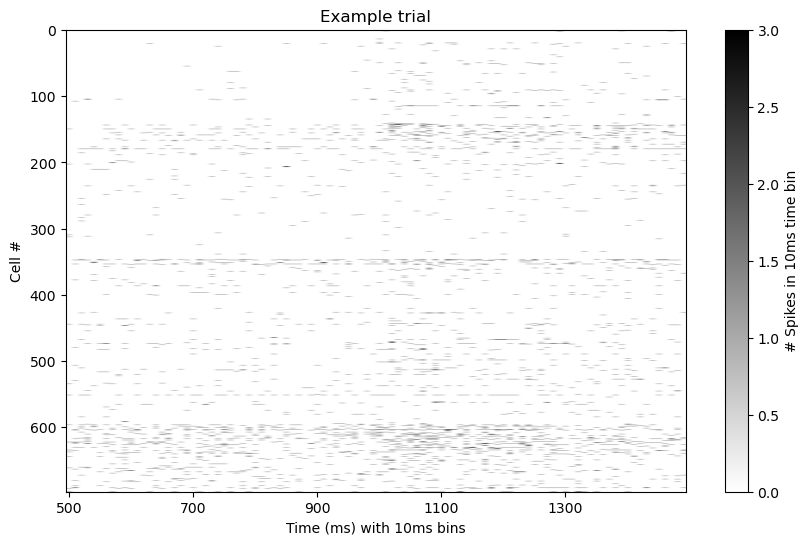

In [10]:
##### Visualise data from one trial to show time slicing
plt.figure(figsize = (10, 6))
plt.imshow(x[0,:,:].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xticks([0, 20, 40, 60, 80], [500, 700, 900, 1100, 1300]) 
plt.xlabel('Time (ms) with 10ms bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 10ms time bin')
plt.title('Example trial')
plt.show()

##### Dataloader

In [11]:
# batch_size of 34 used to match number of trials
batch_size = 34

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparameters

In [12]:
# number of hidden RNN stages, inputs and outputs
hidden_size = x.shape[1]
input_size = x.shape[2]
output_size = y_train.shape[1]
num_layers = 1
learning_rate = 0.001
number_of_epochs = 1000

# try similar epochs
RNN_number_of_epochs = 70
LSTM_number_of_epochs = 70
GRU_number_of_epochs = 70

# early stopping not used
# RNN_patience = 5
# LSTM_patience = 5
# GRU_patience = 5

In [13]:
print(hidden_size)
print(input_size)
print(output_size)

100
698
3


##### Define RNN
Since the `hidden_size` is 250 we can expect to see either exploding or vanishing gradients in the RNN. For this case we can't expect the RNN to be able to predict well. But, as Dev did, we can reduce the `hidden_size` by slicing off data which doesn't correspond to wheel movement. 

In [14]:
# chatgpt 3.5 generated code
# RNN Model with Softmax
class RNNWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer to map RNN output to class labels
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)

        # Use only the last time step's output for classification
        out = self.fc(out[:, -1, :]) 

        # Apply softmax activation
        return nn.functional.softmax(out, dim=1)  

##### Train the RNN: setup

In [15]:
# chatgpt 3.5 generated code
model = RNNWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Train the RNN and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

In [16]:
# chatgpt 3.5 generated code
# Training loop
# RNN_total_epochs = number_of_epochs
RNN_total_epochs = RNN_number_of_epochs

# Early stopping parameters
# best_val_loss = float('inf')
# epochs_since_best = 0

# Number of epochs to wait for improvement in validation loss
# patience = RNN_patience

# Lists to store training/validation losses and training/validation accuracies
RNN_train_losses = []  
RNN_val_losses = []    
RNN_train_accuracies = []  
RNN_val_accuracies = []    

for epoch in range(RNN_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    RNN_train_losses.append(average_train_loss)
    RNN_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Check if validation loss has improved
    # if average_val_loss < best_val_loss:
    #    best_val_loss = average_val_loss
    #    epochs_since_best = 0
    # else:
    #    epochs_since_best += 1

    # Store validation loss and accuracy values
    RNN_val_losses.append(average_val_loss)
    RNN_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    # if epochs_since_best >= patience:
    #    print(f"Early stopping at epoch {epoch + 1}. Validation loss did not improve for {patience} epochs.")
    #    break


Epoch [1/70], Training Loss: 1.08710718, Training Accuracy: 0.3782
Epoch [1/70], Validation Loss: 1.06774420, Validation Accuracy: 0.3824
Epoch [2/70], Training Loss: 1.02711328, Training Accuracy: 0.5882
Epoch [2/70], Validation Loss: 1.05101490, Validation Accuracy: 0.4265
Epoch [3/70], Training Loss: 0.97664487, Training Accuracy: 0.6975
Epoch [3/70], Validation Loss: 1.04044276, Validation Accuracy: 0.4853
Epoch [4/70], Training Loss: 0.92203795, Training Accuracy: 0.7311
Epoch [4/70], Validation Loss: 1.02752650, Validation Accuracy: 0.5000
Epoch [5/70], Training Loss: 0.85079129, Training Accuracy: 0.8025
Epoch [5/70], Validation Loss: 0.99793631, Validation Accuracy: 0.5441
Epoch [6/70], Training Loss: 0.75992611, Training Accuracy: 0.8445
Epoch [6/70], Validation Loss: 0.86526230, Validation Accuracy: 0.7206
Epoch [7/70], Training Loss: 0.69898501, Training Accuracy: 0.9034
Epoch [7/70], Validation Loss: 0.95926929, Validation Accuracy: 0.5882
Epoch [8/70], Training Loss: 0.651

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


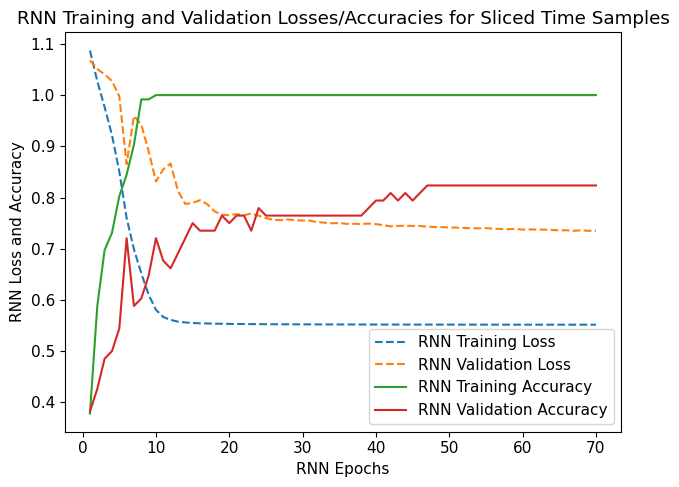

In [17]:
# Plot the losses and accuracies at the end of all epochs
RNN_x_epochs = list(range(1, RNN_total_epochs + 1))
plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 11})

# Plot losses (dashed) and accuracies (solid)
plt.plot(RNN_x_epochs, RNN_train_losses, linestyle='--', label='RNN Training Loss')
plt.plot(RNN_x_epochs, RNN_val_losses, linestyle='--', label='RNN Validation Loss')
plt.plot(RNN_x_epochs, RNN_train_accuracies, label='RNN Training Accuracy')
plt.plot(RNN_x_epochs, RNN_val_accuracies, label='RNN Validation Accuracy')
plt.xlabel('RNN Epochs')
plt.ylabel('RNN Loss and Accuracy')
plt.title('RNN Training and Validation Losses/Accuracies for Sliced Time Samples')
plt.legend()

plt.tight_layout()
plt.savefig('eps/RNN_11_base_spks_class_corrected.eps')
plt.savefig('svg/RNN_11_base_spks_class_corrected.svg')
plt.show()

##### Testing 

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.85294


##### Analysis RNN
Validation accuracy is 0.8235 at 70 epochs. Test accuracy is 0.85294.

##### Define LSTM

In [13]:
# chatgpt 3.5 generated code
# LSTM Model with Softmax
class LSTMWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train LSTM: setup 

In [14]:
# chatgpt 3.5 generated code
model = LSTMWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the LSTM and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

In [15]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# LSTM_total_epochs = number_of_epochs
LSTM_total_epochs = LSTM_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
LSTM_train_losses = []  
LSTM_val_losses = []    
LSTM_train_accuracies = []  
LSTM_val_accuracies = []    

for epoch in range(LSTM_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    LSTM_train_losses.append(average_train_loss)
    LSTM_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    LSTM_val_losses.append(average_val_loss)
    LSTM_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/70], Training Loss: 1.09020155, Training Accuracy: 0.3655
Epoch [1/70], Validation Loss: 1.07230395, Validation Accuracy: 0.4265
Epoch [2/70], Training Loss: 1.04953301, Training Accuracy: 0.4454
Epoch [2/70], Validation Loss: 1.04872417, Validation Accuracy: 0.4265
Epoch [3/70], Training Loss: 1.01954140, Training Accuracy: 0.5840
Epoch [3/70], Validation Loss: 1.03435397, Validation Accuracy: 0.5294
Epoch [4/70], Training Loss: 0.97068191, Training Accuracy: 0.7353
Epoch [4/70], Validation Loss: 0.96423846, Validation Accuracy: 0.6618
Epoch [5/70], Training Loss: 0.86044398, Training Accuracy: 0.7227
Epoch [5/70], Validation Loss: 1.07448930, Validation Accuracy: 0.3971
Epoch [6/70], Training Loss: 0.93588800, Training Accuracy: 0.5756
Epoch [6/70], Validation Loss: 0.98601416, Validation Accuracy: 0.4559
Epoch [7/70], Training Loss: 0.87668255, Training Accuracy: 0.7143
Epoch [7/70], Validation Loss: 0.94710112, Validation Accuracy: 0.6471
Epoch [8/70], Training Loss: 0.798

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


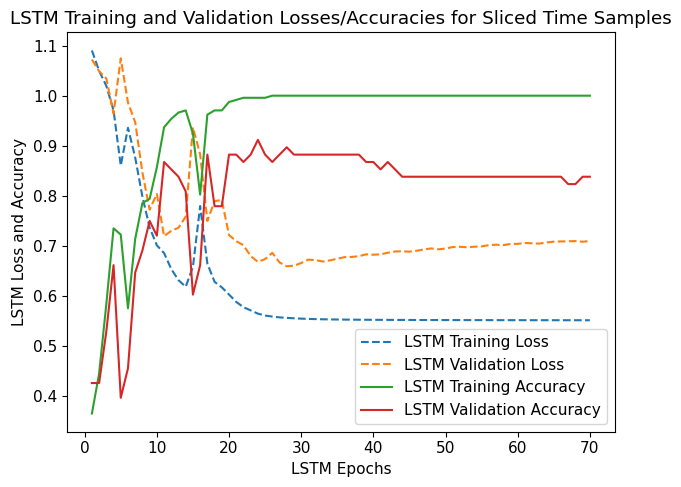

In [16]:
# Plot the losses and accuracies at the end of all epochs
LSTM_x_epochs = list(range(1, LSTM_total_epochs + 1))
plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 11})

# Plot losses (dashed) and accuracies (solid)
plt.plot(LSTM_x_epochs, LSTM_train_losses, linestyle='--', label='LSTM Training Loss')
plt.plot(LSTM_x_epochs, LSTM_val_losses, linestyle='--', label='LSTM Validation Loss')
plt.plot(LSTM_x_epochs, LSTM_train_accuracies, label='LSTM Training Accuracy')
plt.plot(LSTM_x_epochs, LSTM_val_accuracies, label='LSTM Validation Accuracy')
plt.xlabel('LSTM Epochs')
plt.ylabel('LSTM Loss and Accuracy')
plt.title('LSTM Training and Validation Losses/Accuracies for Sliced Time Samples')
plt.legend()

plt.tight_layout()
plt.savefig('eps/LSTM_11_base_spks_class_corrected.eps')
plt.savefig('svg/LSTM_11_base_spks_class_corrected.svg')
plt.show()

##### Testing 

In [17]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.85294


##### Analysis LSTM
Validation accuracy is 0.8382 at 70 epochs. Test accuracy is 0.85294. This model should be stopped at 30 epochs.



##### Define GRU

In [14]:
# chatgpt 3.5 generated code
# GRU Model with Softmax
class GRUWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train GRU: setup 

In [15]:
# chatgpt 3.5 generated code
model = GRUWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the GRU and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

In [16]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# GRU_total_epochs = number_of_epochs
GRU_total_epochs = GRU_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
GRU_train_losses = []  
GRU_val_losses = []    
GRU_train_accuracies = []  
GRU_val_accuracies = []    

for epoch in range(GRU_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    GRU_train_losses.append(average_train_loss)
    GRU_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    GRU_val_losses.append(average_val_loss)
    GRU_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/70], Training Loss: 1.07781133, Training Accuracy: 0.4118
Epoch [1/70], Validation Loss: 1.05356115, Validation Accuracy: 0.4412
Epoch [2/70], Training Loss: 1.02585598, Training Accuracy: 0.6218
Epoch [2/70], Validation Loss: 1.03866106, Validation Accuracy: 0.5441
Epoch [3/70], Training Loss: 0.99436565, Training Accuracy: 0.7185
Epoch [3/70], Validation Loss: 1.02434880, Validation Accuracy: 0.5588
Epoch [4/70], Training Loss: 0.95432305, Training Accuracy: 0.7521
Epoch [4/70], Validation Loss: 1.00095123, Validation Accuracy: 0.6029
Epoch [5/70], Training Loss: 0.88747850, Training Accuracy: 0.7563
Epoch [5/70], Validation Loss: 0.92131299, Validation Accuracy: 0.7206
Epoch [6/70], Training Loss: 0.79202444, Training Accuracy: 0.7563
Epoch [6/70], Validation Loss: 0.78529045, Validation Accuracy: 0.7647
Epoch [7/70], Training Loss: 0.75991002, Training Accuracy: 0.7689
Epoch [7/70], Validation Loss: 0.86035454, Validation Accuracy: 0.6912
Epoch [8/70], Training Loss: 0.733

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


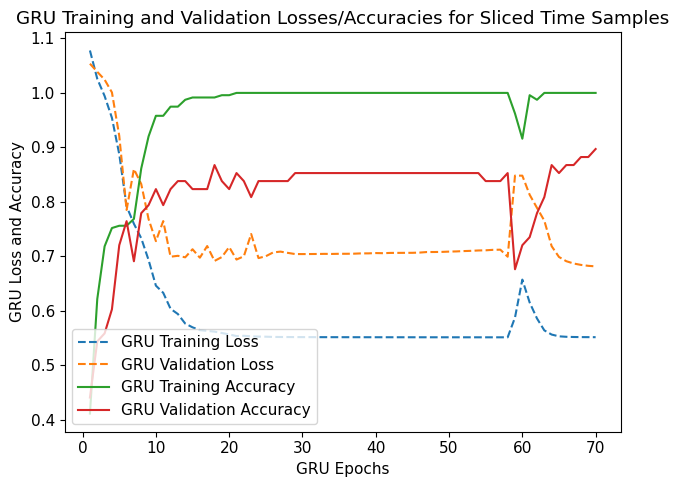

In [17]:
# Plot the losses and accuracies at the end of all epochs
GRU_x_epochs = list(range(1, GRU_total_epochs + 1))
plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 11})

# Plot losses (dashed) and accuracies (solid)
plt.plot(GRU_x_epochs, GRU_train_losses, linestyle='--', label='GRU Training Loss')
plt.plot(GRU_x_epochs, GRU_val_losses, linestyle='--', label='GRU Validation Loss')
plt.plot(GRU_x_epochs, GRU_train_accuracies, label='GRU Training Accuracy')
plt.plot(GRU_x_epochs, GRU_val_accuracies, label='GRU Validation Accuracy')
plt.xlabel('GRU Epochs')
plt.ylabel('GRU Loss and Accuracy')
plt.title('GRU Training and Validation Losses/Accuracies for Sliced Time Samples')
plt.legend()

plt.tight_layout()
plt.savefig('eps/GRU_11_base_spks_class_corrected.eps')
plt.savefig('svg/GRU_11_base_spks_class_corrected.svg')
plt.show()

##### Testing

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.85294


##### Analysis GRU
Validation accuracy is 0.8971 at 70 epochs. Test accuracy is 0.85294. This model should've run longer.

##### Final notes
__class balanced train, val and test sets__
|  | epochs | validation accuracy (%) | test accuracy (%) | time (s) 
| --- | --- | ---| --- | --- 
| RNN | 70 | 82.35 | 85.294 | 1.2 
| LSTM | 70 | 83.82 | 85.294 | 1.5 
| GRU | 70 | 89.71 | 85.294 | 1.4 

__randomly balanced classes in train, val and test sets__
|  | epochs | validation accuracy (%) | test accuracy (%) | time (s) 
| --- | --- | ---| --- | --- 
| RNN | 70 | 86.76 | 88.235 | 1.4 
| LSTM | 70 | 89.71 | 85.294 | 1.8 
| GRU | 70 | 85.29 | 88.235 | 1.5 

__classification balance errors on -1, 0, 1 labels before correction, in percent__
|  | -1 | 0 | 1 
| --- | --- | --- | ---
| train | -0.71428571 | -1.17647059 | 1.8907563 
| val | 4.11764706 | 3.23529412 | -7.35294118
| test | -3.23529412 | 1.76470588 | 1.47058824

__classification balance errors on -1, 0, 1 labels after correction, in percent__
|  | -1 | 0 | 1 
| --- | --- | --- | ---
| train | 0.12605042 | 0.08403361 | -0.21008403
| val | -0.29411765 | 0.29411765 | 0.        
| test | -0.29411765 | -1.17647059 | 1.47058824

There was a small reduction in validation and test set accuracies for RNN and GRU, about 3%. Both LSTM and GRU may benefit from different epoch settings.

Arjun's premise behind the need to retain the distribution of training classes within the groups has merit, but it also assumes an equal distribution of response across the full experimental time interval. We already found that training on a dataset which wasn't shuffled led to significantly poorer performance because the validation and test sets were taken from trials near the end of the experiment. If more wheel responses to the right, let's say, were made later in the experiment, then the right class would have more end term data in it than the others, which would also skew the results.

A more careful analysis of the data needs to be made. 